https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Multiple Parallel Series

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [4]:
# synthetic sequential data
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

In [5]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if beyond the dataset
    if end_ix > len(sequences)-1:
      break
    # generate input and output
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [6]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
  print(X[i], y[i])

(6, 3, 3) (6, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [ 60  65 125]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [ 70  75 145]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [ 80  85 165]
[[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]] [ 90  95 185]


In [8]:
# vector dimension (the number of features)
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=400, verbose=0)

In [9]:
# demonstrate prediction
x_input = np.array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.75133 106.07922 206.34253]]


Realistic data, NVDA stock price

In [10]:
from google.colab import files
uploaded = files.upload()

Saving NVDA.csv to NVDA.csv


In [11]:
df = pd.read_csv('NVDA.csv', index_col = 'Date', parse_dates=True)
df.iloc[:,0:4].head(5)

,Open,High,Low,Close
Date,,,,
2022-06-28,169.000000,172.020004,159.449997,159.820007
2022-06-29,158.139999,158.199997,151.699997,155.419998
2022-06-30,153.610001,155.669998,148.619995,151.589996
2022-07-01,148.990005,150.630005,143.919998,145.229996
2022-07-05,141.750000,149.710007,140.550003,149.639999


In [12]:
Mdat = df.iloc[:,0:4].to_numpy()

In [14]:
# use the previous 5 vectors to predict the next one
n_steps = 5
# convert into input/output
X, y = split_sequences(Mdat, n_steps)
print(X[0:200,:,:].shape, y[0:200,:].shape)

(200, 5, 4) (200, 4)


In [15]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
# with the first 200 data
seqModel = model.fit(X[0:200,:,:], y[0:200,:], epochs=400, verbose=0)

In [35]:
x_input = X[200:-1,:,:].reshape(X[200:-1,:,:].shape[0], n_steps, n_features)
yhat = model.predict(x_input, verbose=0)
#print(yhat)

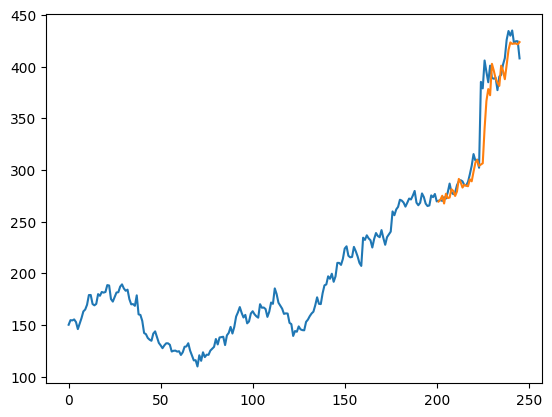

In [34]:
# label = 0:Open  1:High  2:Low  3:Close
label = 0
day_idx = range(y.shape[0])
predict_day_idx = range(200+1,y.shape[0])
plt.figure()
plt.plot(day_idx, y[:,label])
plt.plot(predict_day_idx, yhat[:,label])

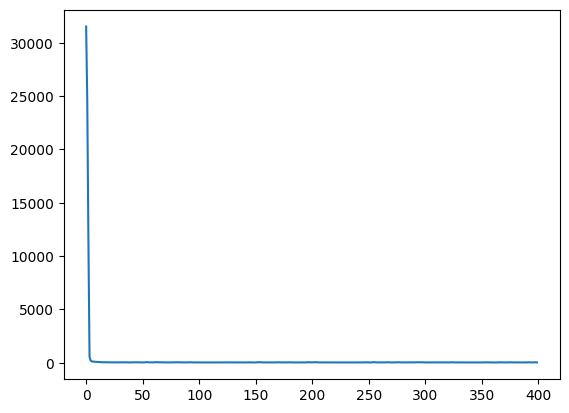

In [ ]:
# visualizing losses and accuracy
train_loss = seqModel.history['loss']
#val_loss   = seqModel.history['val_loss']
#train_acc  = seqModel.history['acc']
#val_acc    = seqModel.history['val_acc']
xc         = range(400)

plt.figure()
plt.plot(xc, train_loss)
#plt.plot(xc, val_loss)